Binomial
Mean: 14.0315
Dispersion: 4.18650775
0.0
Pearson false
Normal
Mean: -1.99925220394
Dispersion: 0.462156441805
0.556997879536
Pearson true
Beta
Mean: 0.505685131104
Dispersion: 0.125135260244
0.596758922541
Pearson true


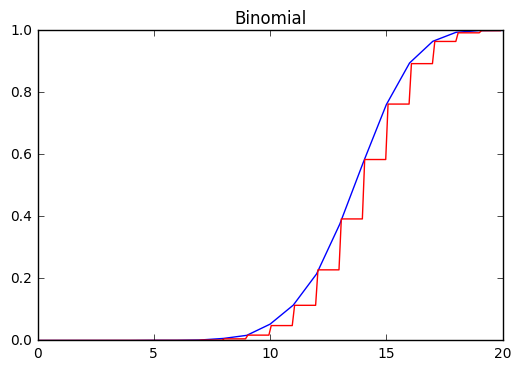

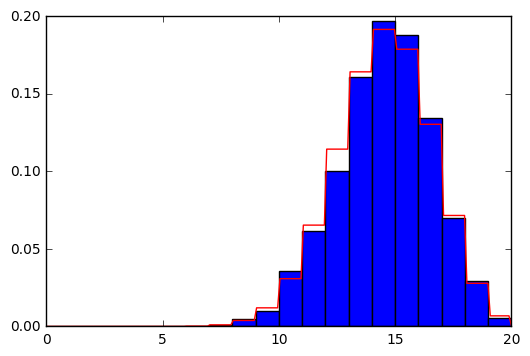

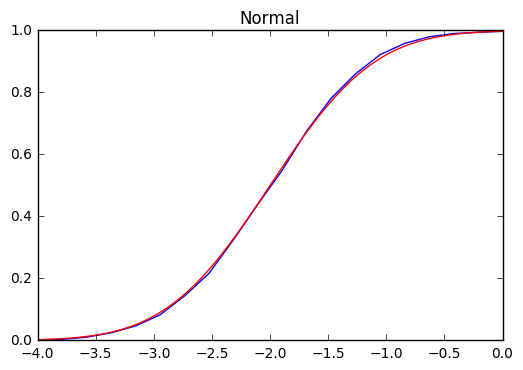

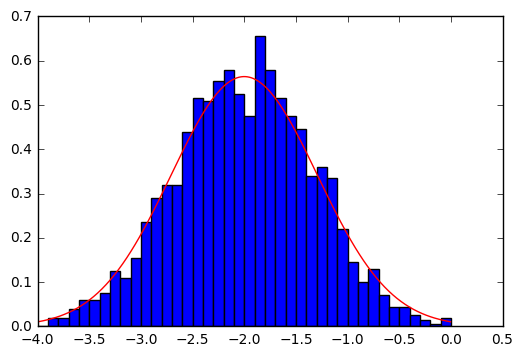

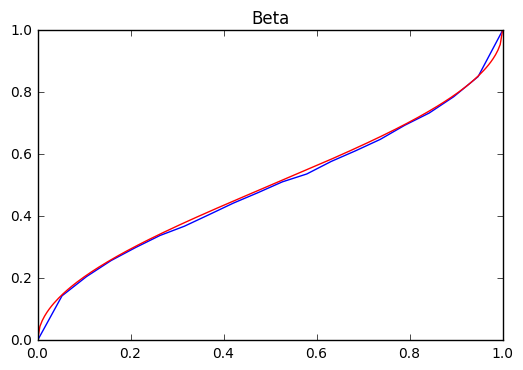

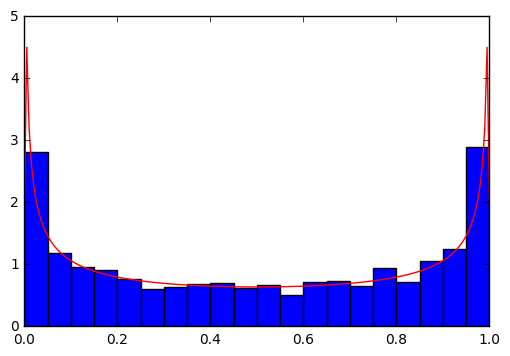

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from math import sin, pi, sqrt, log, erf
from scipy.special import betainc, hyp2f1, gamma, gammainc, beta, binom
import random

def lfsrGen(S, c):
    while True:
        yield S[0]
        S = np.append(S, np.mod(np.sum(S * c), 2))[1:]

def ssGen(g):
    a, b = next(g), next(g)
    while True:
        if a == 1:
            yield b
        a, b = b, next(g)

def uniformVal():
    bits = 32
    S = np.random.randint(2, size=bits)
    c = np.array([1 if x in [0, 24, 25, 29, 31] else 0 for x in range(bits)])
    g = ssGen(lfsrGen(S, c))
    while True:
        yield (int(''.join([str(next(g)) for _ in range(bits)]), 2) + 1) / (2 ** bits + 1)

def hvs(x):
    if x >= 0:
        return 1
    else:
        return 0

def empiricalFunc(seq, x):
    return np.mean([hvs(x - q) for q in seq])

def binomialVal(n=20, p=0.7):
    vals = [uniformVal() for _ in range(n)]
    while True:
        k = 0
        for val in vals:
            if next(val) < p:
                k += 1
        yield k

def normalVal(E=-2,D=0.5):
    r = uniformVal()
    phi = uniformVal()
    while True:
        z = sin(2*pi*next(phi)) * sqrt(-2*log(next(r)))
        yield E + sqrt(D) * z

def betaVal(a=0.5, b=0.5):
    u1 = uniformVal()
    u2 = uniformVal()
    while True:
        cu1 = next(u1)
        cu2 = next(u2)
        y = cu1**(1/a) + cu2**(1/b) 
        if y <= 1:
            yield cu1**(1/a) / y

def pearson(cls, vs, n, f0): 
    k = len(cls) - 1 
    ps = [] 
    for i in range(k): 
        ps.append(f0(cls[i+1]) - f0(cls[i])) 
    xsqs = [] 
    for i in range(k): 
        xsqs.append((vs[i] - n*ps[i])**2/(n*ps[i])) 
    xsq = np.sum(xsqs) 
    return 1.0 - gammainc((k-1)/2,xsq/2)
def binomialDistribution(x, n=20, p=0.7):
    return betainc(n - int(x), int(x) + 1, 1.0 - p) if x > 0 else 0
def binomialDensity(x, n=20, p=0.7):
    return binom(n, int(x))*p**(int(x))*(1-p)**(n-int(x)) if x > 0 else 0
def normalDistribution(x, E=-2, D=0.5):
    return (1 + erf((x - E) / sqrt(2 * D))) * 0.5
def normalDensity(x, E=-2, D=0.5):
    return (np.exp(-(x - E)**2 / (2*D))) / (sqrt(D)*sqrt(2*pi))
def betaDistribution(x, a=0.5, b=0.5):
    return betainc(a, b, x)
def betaDensity(x, a=0.5, b=0.5):
    return x**(a-1)*(1-x)**(b-1) / beta(a, b) if x != 0 and x != 1 else 2

laws = [((0,20,21),(0,20,1),[("Binomial",binomialVal(),binomialDistribution,binomialDensity)]),
        ((-4,0,20),(-4,0,0.1),[("Normal",normalVal(),normalDistribution,normalDensity)]),
        ((0,1,20),(0,1,0.05),[("Beta",betaVal(),betaDistribution,betaDensity)])]
for xsprms, hst, vals in laws:
    for name, val, dfunc, densf in vals:
        print(name)
        seq = [next(val) for _ in range(2000)]
        mn = np.mean(seq)
        print("Mean: " + str(mn))
        disp = np.mean((seq - mn)**2)
        print("Dispersion: " + str(disp))
        sl, sr, xscnt = xsprms
        xs = np.linspace(sl, sr, xscnt)
        plt.figure()
        plt.title(name)
        plt.plot(xs, [empiricalFunc(seq,x) for x in xs], c='b')
        xs = np.linspace(sl, sr, 200)
        plt.plot(xs, [dfunc(x) for x in xs], c='r')
        plt.figure()
        l, r, step = hst
        vs = []
        cls = np.arange(l,r,step)
        for cl in cls:
            cnt = 0
            for s in seq:
                if s >= cl and s < cl + step:
                    cnt += 1
            vs.append(cnt)
        n = len(seq)
        h = [v / (step*n) for v in vs]
        plt.bar(cls,h,step)
        xs = np.linspace(l,r,200)
        plt.plot(xs, [densf(x) for x in xs], c='r')
        pval = pearson(cls, vs, len(seq), dfunc)
        print(pval)
        print("Pearson true" if 0.037 < pval else "Pearson false")